In [1]:
import matplotlib.pyplot as plt
import joblib

X_train, X_test, y_train, y_test = joblib.load('artifacts/final_census_data.pkl')

In [2]:
y_probas = {}
ap_scores = {}  # store average precision

In [3]:
from sklearn.metrics import (
    roc_auc_score, precision_score, recall_score, 
    f1_score, accuracy_score, average_precision_score
)
from sklearn.base import ClassifierMixin

def evaluate_model(model: ClassifierMixin, X_test, y_test, name=None):
    # Predict labels
    y_pred = model.predict(X_test)
    
    # Predict probabilities / scores
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_proba = model.decision_function(X_test)
    else:
        y_proba = None

    # Collect metrics
    metrics = {
        "Model": name if name else model.__class__.__name__,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred, average='weighted'),
    }
    if y_proba is not None:
        metrics["ROC-AUC"] = roc_auc_score(y_test, y_proba)
        
    if hasattr(model, "predict_proba"):
        y_scores = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_scores = model.decision_function(X_test)

    # Save
    y_probas[name] = y_scores
    ap_scores[name] = average_precision_score(y_test, y_scores)
    
    return metrics

# Decision Tree

In [4]:
from sklearn.tree import DecisionTreeClassifier
model_name = "Decision Tree"

dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [5]:
evaluate_model(dt_model, X_test, y_test, model_name)

{'Model': 'Decision Tree',
 'Accuracy': 0.805537024683122,
 'Precision': 0.5739932071809801,
 'Recall': 0.8042148198504419,
 'F1': 0.8149980582524826,
 'ROC-AUC': 0.8802526938865957}

# Random Forest

In [6]:
from sklearn.ensemble import RandomForestClassifier
model_name = "Random Forest"

rf_model = RandomForestClassifier(class_weight='balanced', random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [7]:
evaluate_model(rf_model, X_test, y_test, model_name)

{'Model': 'Random Forest',
 'Accuracy': 0.8105403602401601,
 'Precision': 0.5804901489668428,
 'Recall': 0.8212100611828688,
 'F1': 0.8199621268084761,
 'ROC-AUC': 0.8949597184611514}

Use F1-score

Why: Balances precision and recall, so it doesn’t favor the majority class.

When: After SMOTE-NC, classes are balanced in training, but test set should stay imbalanced — so the F1 gives a fairer view.

# Base Classification Evaluation

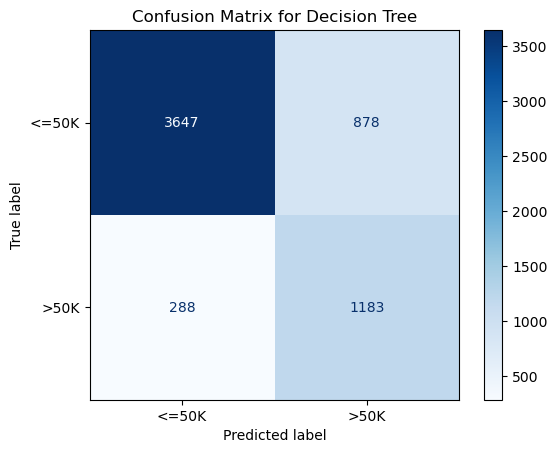

In [8]:
# Plot classification matrix on test data for both models
from sklearn.metrics import ConfusionMatrixDisplay

disp = ConfusionMatrixDisplay.from_estimator(
    dt_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Decision Tree")
plt.show()

In [9]:
from sklearn.metrics import classification_report

y_pred = dt_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.86      4525
           1       0.57      0.80      0.67      1471

    accuracy                           0.81      5996
   macro avg       0.75      0.81      0.77      5996
weighted avg       0.84      0.81      0.81      5996



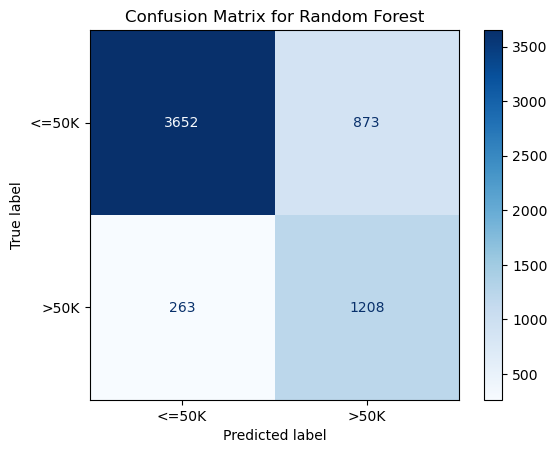

In [10]:
disp = ConfusionMatrixDisplay.from_estimator(
    rf_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Random Forest")
plt.show()

In [11]:
y_pred = rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.93      0.81      0.87      4525
           1       0.58      0.82      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.81      0.77      5996
weighted avg       0.85      0.81      0.82      5996



# Hyperparameter Tuning

## Decision Tree

In [ ]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold

# Parameter grid for Decision Tree
param_grid = {
    'criterion': ['gini', 'entropy', 'log_loss'],  # Split quality metrics
    'max_depth': [None, 5, 10, 15, 20, 30],         # Limit depth to prevent overfitting
    'min_samples_split': [2, 5, 10],                # Min samples to split
    'min_samples_leaf': [1, 2, 4],                  # Min samples per leaf
    'max_features': ['sqrt', 'log2']          # Randomness in feature selection
}

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Grid search setup
grid_dt = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=1
)

# Fit model
grid_dt.fit(X_train, y_train)
best_dt_model = grid_dt.best_estimator_

# Results
print("Best Parameters:", grid_dt.best_params_)
print("Best F1 Score: {:.4f}".format(grid_dt.best_score_))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2}
Best F1 Score: 0.8458


In [25]:
evaluate_model(
    best_dt_model, 
    X_test, 
    y_test, 
    "Decision Tree (Grid Search)"
)

{'Model': 'Decision Tree (Grid Search)',
 'Accuracy': 0.8100400266844563,
 'Precision': 0.580896686159844,
 'Recall': 0.8103331067301156,
 'F1': 0.8191878458866053,
 'ROC-AUC': 0.8863254598104795}

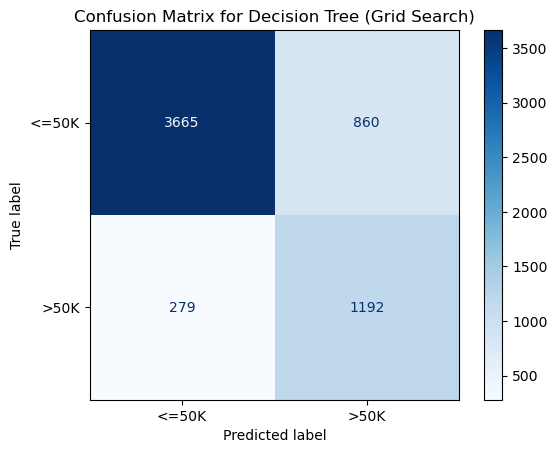

In [26]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_dt_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Decision Tree (Grid Search)")
plt.show()

## Random Forest

In [18]:
#  Grid Search Hyperparameter Tuning (Random Forest)
from sklearn.model_selection import GridSearchCV
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=RandomForestClassifier(class_weight='balanced', random_state=42),
    param_grid=param_grid,
    scoring='f1',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
best_rf_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Hyperparameters: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 200}


In [19]:
evaluate_model(best_rf_model, X_test, y_test, "Random Forest (Grid Search)")

{'Model': 'Random Forest (Grid Search)',
 'Accuracy': 0.8112074716477652,
 'Precision': 0.580829756795422,
 'Recall': 0.8280081577158396,
 'F1': 0.8207544209081981,
 'ROC-AUC': 0.9004787963237697}

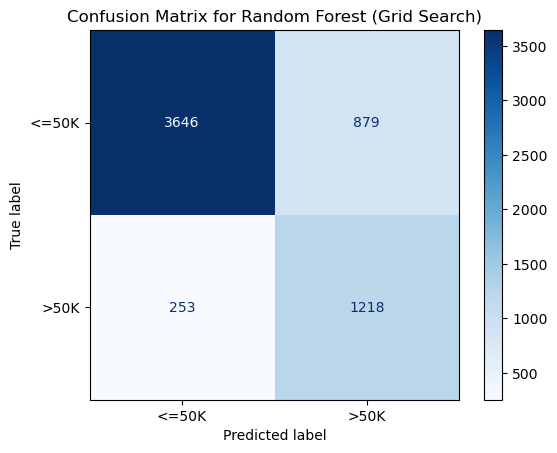

In [20]:
disp = ConfusionMatrixDisplay.from_estimator(
    best_rf_model,
    X_test,
    y_test,
    display_labels=["<=50K", ">50K"],
    cmap=plt.cm.Blues,
    normalize=None
)
disp.ax_.set_title(f"Confusion Matrix for Random Forest (Grid Search)")
plt.show()

In [21]:
y_pred = best_rf_model.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      4525
           1       0.58      0.83      0.68      1471

    accuracy                           0.81      5996
   macro avg       0.76      0.82      0.77      5996
weighted avg       0.85      0.81      0.82      5996



# Final Classification Evaluation

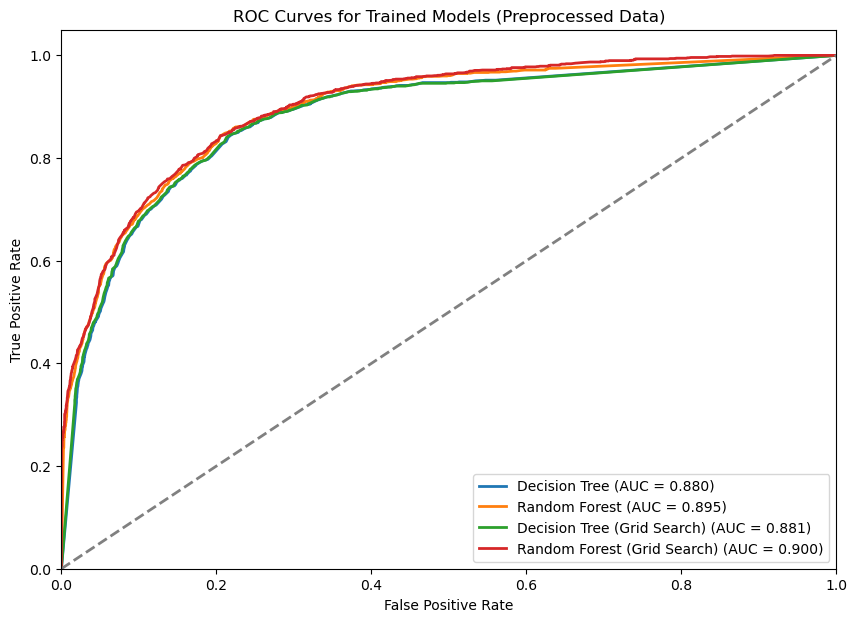

In [22]:
from sklearn.metrics import roc_curve, auc
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 7))

for name, y_proba in y_probas.items():
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")

# Baseline (random classifier)
plt.plot([0, 1], [0, 1], color="gray", lw=2, linestyle="--")

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Trained Models (Preprocessed Data)")
plt.legend(loc="lower right")
plt.show()

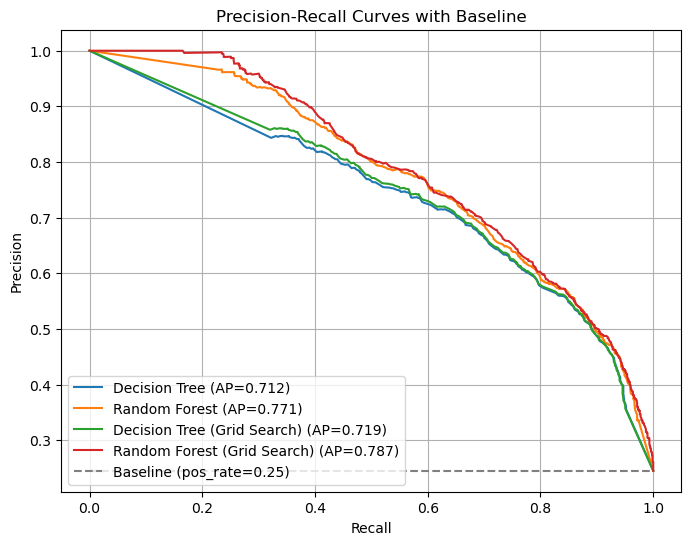

In [23]:
from sklearn.metrics import precision_recall_curve
import numpy as np

# Proportion of positive class in test set
pos_rate = np.mean(y_test)

plt.figure(figsize=(8,6))
for name, y_scores in y_probas.items():
    precision, recall, _ = precision_recall_curve(y_test, y_scores)
    ap = average_precision_score(y_test, y_scores)
    plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")

# Add baseline
plt.hlines(pos_rate, 0, 1, colors="gray", linestyles="--", label=f"Baseline (pos_rate={pos_rate:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves with Baseline")
plt.legend()
plt.grid(True)
plt.show()